In [1]:
import re
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)

In [2]:
train = pd.read_csv('./input/train.csv')
submission_test = pd.read_csv('./input/test.csv')

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


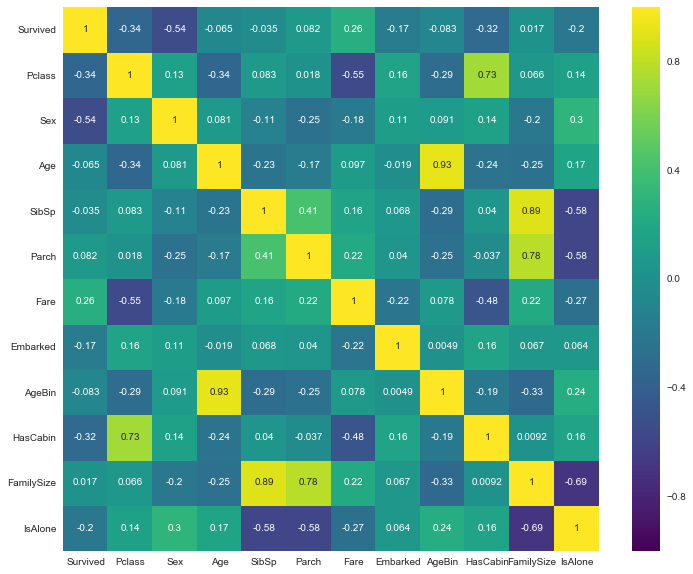

In [3]:
# Preprocess
full_data = [train, submission_test]

# Sex
for data in full_data:
    data['Sex'] = LabelEncoder().fit_transform(data['Sex']) 
    
# Fare
for data in full_data:
    data['Fare'] = data['Fare'].fillna(data['Fare'].median())

# Age ビンニング
bins = [ 0, 4, 12, 18, 30, 50, 65, 100]
age_index = (1,2,3,4,5,6,7)
for data in full_data:
    data['Age'] = data['Age'].fillna(data['Age'].median())
    data['AgeBin'] = pd.cut(data['Age'], bins, labels=age_index).astype(int)

# Cabin NaNとそれ以外で分ける
for data in full_data:
    data['HasCabin'] = data['Cabin'].isnull().astype(int)

# Embarked
for data in full_data:
    data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
    data['Embarked'] = LabelEncoder().fit_transform(data['Embarked'])
    
# Create new feature FamilySize as a combination of SibSp and Parch
for data in full_data:
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    
# Create new feature IsAlone from FamilySize
for data in full_data:
    data['IsAlone'] = 0
    data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1

# Feature Correlation
sns.heatmap(train.ix[:,1:].corr(), cmap=plt.cm.viridis, annot=True)

In [4]:
feature_cols = ['Pclass', 'Sex', 'Fare', 'HasCabin', 'Embarked', 'AgeBin', 'IsAlone']

train_X = train[feature_cols]
train_Y = train['Survived']
lgb_train = lgb.Dataset(train_X, train_Y)

test_X = submission_test[feature_cols].as_matrix()

In [5]:
gbm = lgb.LGBMClassifier(num_leaves=15, learning_rate=0.075, max_bin=63, num_iterations=50).fit(train_X, train_Y)
lgb_pred_Y = gbm.predict(test_X)

submission = pd.DataFrame({ 'PassengerId': submission_test['PassengerId'], 'Survived': lgb_pred_Y })
submission.to_csv("submission.csv", index=False)

In [6]:
from sklearn.ensemble import RandomForestClassifier
seed = 1234
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 3,
    'max_features' : 'sqrt',
    'verbose': 0
}

rfc = RandomForestClassifier(**rf_params, random_state=seed).fit(train_X, train_Y)
rf_pred_Y = rfc.predict(test_X)

# rf_importance = pd.DataFrame(rfc.feature_importances_, index=feature_cols)
# rf_importance.plot()

In [7]:
# xgc = xgb.XGBClassifier(n_estimators= 2000, 
#                         max_depth= 4, 
#                         min_child_weight= 2, 
#                         learning_rate=0.1,
#                         gamma=0.8).fit(train_X.as_matrix(), train_Y)
# xgb_pred_Y = xgc.predict(test_X)

In [8]:
# LGB parameter tuning
lgb_tune_params = {
    "num_leaves ": [15, 31, 63, 127],
    'learning_rate' : [0.05, 0.075, 0.1],
    'max_bin': [63, 127, 255],
    'bagging_fraction': [0.8,0.9,1.0]
}

grid = GridSearchCV(lgb.LGBMClassifier(), param_grid=lgb_tune_params)
grid_result = grid.fit(train_X, train_Y)

print(grid_result.best_score_)
grid_result.best_params_

0.802469135802


{'bagging_fraction': 1.0,
 'learning_rate': 0.075,
 'max_bin': 63,
 'num_leaves ': 15}